In [7]:
import requests
import pandas as pd
import os
from bs4 import BeautifulSoup
from urllib import parse
import logging
import re

appdirectdoc = 'data/appdirect-pages.csv'
appdirect_url = 'https://www.appdirect.com'
cols = ['url', 'status', 'title', 'heading', 'text', 'word_count', 'num_links', 'link_text', 'link_word_count', 'description', 'keywords']
hrefs_to_skip = ['#', 'javascript:', 'mailto:', '.rss', '.pdf', '.xml', '.svg']

visited_urls = []
urls_to_visit = []

logging.basicConfig(
    format='%(asctime)s %(levelname)s:%(message)s',
    level=logging.INFO)

def init_archive():
    df = pd.DataFrame(columns = cols)
    os.makedirs("data", exist_ok=True)
    df.to_csv(appdirectdoc)

def load_csv_archive():
    return pd.read_csv(appdirectdoc)

def save_csv_archive(df):
    os.makedirs("data", exist_ok=True)
    df.to_csv(appdirectdoc, index=False)

def add_links(links):
    for link in links:
        #print(link)
        href = link.get('href')
        # prepend starting url to relative url
        if href[0] == '/':
            href = parse.urljoin(appdirect_url, href)
        # don't add urls that are in the hrefs_to_skip list
        if any(skippable in href for skippable in hrefs_to_skip):
            continue
        # ignore anything not in domain
        if not href.startswith(appdirect_url):
            continue
        # if we haven't already visited it and it's not already on our list to visit
        if href not in urls_to_visit and href not in visited_urls:
            urls_to_visit.append(href)


def process_page(url):
    try:
        page = requests.get(url)
    except Exception:
        logging.exception(f'Failed to crawl: {url}')
        pass
    status = page.status_code
    soup = BeautifulSoup(page.content, 'html.parser')

    title = soup.find('title').get_text()
    
    og_description = None if soup.find('meta', property='description') is None else soup.find('meta', property='description').get('content')
    keywords = None if soup.find('meta', property='keywords') is None else soup.find('meta', property='keywords').get('content')

    real_content = soup.find_all('main', id='content')
    heading = soup.find('h1')
    text = ''
    for section in real_content:
        text += ' '.join(section.get_text(" ").split()) + ' '
    all_links = []
    for section in real_content:
        for link in section.find_all('a', href=True):
            all_links.append(link)

    word_count = len(text.split())
    num_links = len(all_links)

    link_text = ''
    for link in all_links:
        link_text += ' '.join(link.get_text(" ").split()) + ' '

    link_word_count = len(link_text.split())

    # add urls to lists:
    if len(all_links) > 0:
        add_links(all_links)
    
    return {'url': url,
            'status': status,
            'title': title, 
            'heading': heading, 
            'text': text, 
            'word_count': word_count, 
            'num_links': num_links, 
            'link_text': link_text, 
            'link_word_count': link_word_count,
            'description': og_description,
            'keywords': keywords }

In [8]:
init_archive()
df = load_csv_archive()

def run():
    first_page = process_page(appdirect_url)
    new_row = pd.Series(first_page).to_frame().T
    df = pd.concat([load_csv_archive(), new_row], ignore_index=True)
    save_csv_archive(df)

    while urls_to_visit:
        url = urls_to_visit.pop(0)
        visited_urls.append(url)
        logging.info(f'Crawling: {url}')
        row = process_page(url)
        updated = pd.concat([load_csv_archive(), pd.Series(row).to_frame().T], ignore_index=True)
        save_csv_archive(updated)



run()


2023-07-17 21:51:35,337 INFO:Crawling: https://www.appdirect.com/store/signup?ref=hphero
2023-07-17 21:51:37,707 INFO:Crawling: https://www.appdirect.com/customers/vodafone
2023-07-17 21:51:39,361 INFO:Crawling: https://www.appdirect.com/customers/adp
2023-07-17 21:51:40,976 INFO:Crawling: https://www.appdirect.com/customers/coupa
2023-07-17 21:51:42,655 INFO:Crawling: https://www.appdirect.com/customers/deutsche-telekom
2023-07-17 21:51:44,376 INFO:Crawling: https://www.appdirect.com/customers/keller-williams
2023-07-17 21:51:46,073 INFO:Crawling: https://www.appdirect.com/resources/forrester-new-wave-marketplace-development-platforms-q4-2021?ref=home
2023-07-17 21:51:48,099 INFO:Crawling: https://www.appdirect.com/products/appmarket?ref=hptab
2023-07-17 21:51:51,428 INFO:Crawling: https://www.appdirect.com/platform/digital-procurement-management?ref=what-module
2023-07-17 21:51:53,436 INFO:Crawling: https://www.appdirect.com/products/appmarket
2023-07-17 21:51:55,997 INFO:Crawling: h

In [10]:
appdirect = load_csv_archive()
appdirect.drop('Unnamed: 0', inplace=True, axis=1)

appdirect.describe()


,word_count,num_links,link_word_count,description,keywords,status
count,1094.000000,1094.000000,1094.000000,0.0,0.0,1094.000000
mean,793.460695,18.384826,66.684644,NaN,NaN,211.188300
std,1481.850784,15.286558,88.209931,NaN,NaN,46.467287
min,0.000000,0.000000,0.000000,NaN,NaN,200.000000
25%,157.500000,9.000000,26.000000,NaN,NaN,200.000000
50%,308.000000,15.000000,52.000000,NaN,NaN,200.000000
75%,821.750000,29.000000,101.000000,NaN,NaN,200.000000
max,12289.000000,267.000000,1524.000000,NaN,NaN,404.000000


In [11]:
c = appdirect[appdirect.word_count != 0]
c = c[c['url'].str.contains("/legal") == False]
c = c[c['url'].str.contains("/decoding-digital") == False]
c = c[c['url'].str.contains("/privacy") == False]

print("MINS")
print(c[c.word_count == c.word_count.min()].url.values)
print("MAXS")
print(c[c.word_count == c.word_count.max()].url.values)
print("MEDIAN")
print(c.word_count.median())
c.describe()

MINS
['https://www.appdirect.com/engage/sessions']
MAXS
['https://www.appdirect.com/communication-tools-and-strategies-for-remote-teams']
MEDIAN
290.0


,word_count,num_links,link_word_count,description,keywords,status
count,1030.000000,1030.000000,1030.000000,0.0,0.0,1030.000000
mean,484.960194,18.122330,64.492233,NaN,NaN,211.883495
std,516.654047,13.570125,78.134975,NaN,NaN,47.804124
min,8.000000,0.000000,0.000000,NaN,NaN,200.000000
25%,154.000000,9.000000,26.000000,NaN,NaN,200.000000
50%,290.000000,15.000000,50.000000,NaN,NaN,200.000000
75%,627.750000,29.000000,103.000000,NaN,NaN,200.000000
max,4253.000000,153.000000,1468.000000,NaN,NaN,404.000000


word_count         1632.5
num_links            12.0
link_word_count     283.0
dtype: float64


C:\Users\dhoer\AppData\Local\Temp\ipykernel_8676\2985340535.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(c.median())


array([[<Axes: title={'center': 'word_count'}>]], dtype=object)

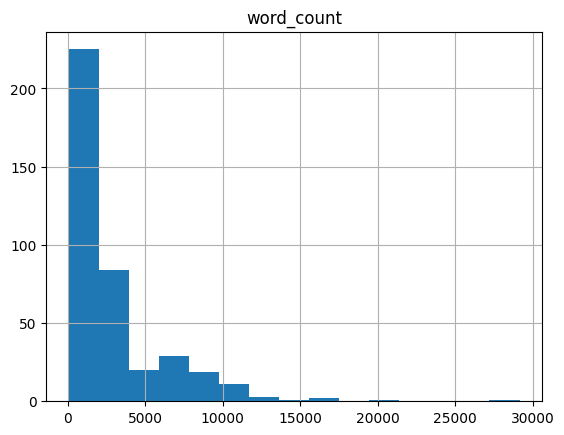

In [35]:

print(c.median())
c.hist(column='word_count', bins=15, label="Stripe.com Word Counts")
#c.describe()